In [1]:
import numpy as np
import pandas as pd
import torch
import re
from torch.utils.data import Dataset, DataLoader
from utils.preprocessing import clean
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Andri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
class BertWhiteningDataset(Dataset):
    LABEL2INDEX = {'world': 0, 'sports': 1, 'business': 2, 'science': 3}
    INDEX2LABEL = {0: 'world', 1: 'sports', 2: 'business', 3: 'science'}
    NUM_LABELS = 4

    def __init__(self, device, dataset_path, tokenizer, model, max_len, *args, **kwargs):
        self.device = device
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.model = model.to(self.device)
        # self.vecs_after, self.vecs_before = self.Dim_reduction(max_len=max_len)
        self.embedding = self.get_embeddings(max_len=max_len)
        
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        # vecs_before = torch.from_numpy(self.vecs_before[index]).unsqueeze(0).float()
        embedding = torch.from_numpy(self.embedding[index]).unsqueeze(0).float()
        vecs, seq_label = embedding, data['target']
        
        return vecs, np.array(seq_label), data['cleaned_text']
    
    def __len__(self):
        return len(self.data)

    def load_dataset(self, path):
        dataset = []
        # Read file
        data = pd.read_csv(path)

        # label encoder
        class_names = set(data.iloc[:,0].values)
        le = LabelEncoder()
        le.fit(data.iloc[:,0])
        class_names = le.classes_

        data['target'] = le.transform(data.iloc[:,0])

        #clean docs
        data['cleaned_text'] = clean(data['Description'])

        return data
    
    def get_embeddings(self, max_len):
        
        if(self.tokenizer is None or self.model is None):
            raise Exception("Sorry, But You must define Tokenizer and Model")
    
        vecs = []
        with torch.no_grad():
          i = 1
          for sentence in self.data['cleaned_text']:
            inputs = self.tokenizer.encode_plus(sentence, return_tensors="pt",max_length=max_len, return_attention_mask=True,truncation=True)
            inputs['input_ids'] = inputs['input_ids'].to(self.device)
            inputs['attention_mask'] = inputs['attention_mask'].to(self.device)

            hidden_states = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], return_dict=True, output_hidden_states=True).hidden_states

            #Averaging the first & last hidden states
            output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)

            vec = output_hidden_state.cpu().numpy()[0]

            print(f'\rWord Embedding Process: {i} / {len(self.data["cleaned_text"])} words | GPU Usages: {(torch.cuda.memory_allocated() / 1048576):3.1f}', end=' ')
            i+=1

            # print(vec.shape)
            vecs.append(vec)
    
        return np.array(vecs)

    def _transform_and_normalize(self, vecs, kernel, bias):
        """
            Applying transformation then standardize
        """
        if not (kernel is None or bias is None):
            vecs = (vecs + bias).dot(kernel)
        return self._normalize(vecs)
        
    def _normalize(self, vecs):
        """
            Standardization
        """
        return vecs / (vecs**2).sum(axis=1, keepdims=True)**0.5
        
    def _compute_kernel_bias_svd(self, vecs):
        """
        Calculate Kernal & Bias for the final transformation - y = (x + bias).dot(kernel)
        """
        vecs = np.concatenate(vecs, axis=0)
        mu = vecs.mean(axis=0, keepdims=True)
        cov = np.cov(vecs.T)
        u, s, vh = np.linalg.svd(cov)
        W = np.dot(u, np.diag(s**0.5))
        W = np.linalg.inv(W.T)
        return W, -mu

    def _compute_kernel_bias_pca(self, vecs):
        vecs = np.concatenate(vecs, axis=0)
        mu = vecs.mean(axis=0, keepdims=True)
        
        # Apply PCA
        pca = PCA()
        pca.fit(vecs)

        # Obtain the transformation matrix W
        W = pca.components_.T

        # Invert and transpose W
        # W = np.linalg.inv(W.T)
        return W, -mu
    
    def _compute_kernel_bias_zca(self, vecs):
        vecs = np.concatenate(vecs, axis=0)
        mu = vecs.mean(axis=0, keepdims=True)
        
        # Center the data
        centered_vecs = vecs - vecs.mean(axis=0, keepdims=True)

        # Apply PCA
        pca = PCA()
        pca.fit(centered_vecs)

        # Calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(pca.components_)

        # Apply ZCA whitening
        zca_matrix = eigenvectors * np.diag(1 / np.sqrt(eigenvalues + 1e-5)) @ eigenvectors.T

        # Return ZCA whitening matrix and mean
        return zca_matrix, -mu

    def _compute_kernel_bias_sphere(self, vecs):
        vecs = np.concatenate(vecs, axis=0)
        mu = vecs.mean(axis=0, keepdims=True)

        # Normalize data length
        normalized_vecs = vecs / np.linalg.norm(vecs, axis=1)[:, np.newaxis]

        # Return whitening matrix (identity matrix in this case) and mean
        return np.eye(normalized_vecs.shape[1]), -mu

    def save_array(self, array, filename):
        vecs = np.array(array)
        vecs.save(f'{filename}.npy', vecs)

    #Defining a function to extract feature using Bert and Dimensionality Reduction
    def Dim_reduction(self, dim_reduction_func='whitening', target_dim=256):
        '''
            This method will accept array of sentences, roberta tokenizer & model
            next it will call methods for dimention reduction
        '''
        
        torch.cuda.empty_cache()

        vecs = self.embedding

        match dim_reduction_func:
            case "pca":
                kernel, bias = self._compute_kernel_bias_pca([vecs])
            case "zca":
                kernel, bias = self._compute_kernel_bias_zca([vecs])
            case "sphere":
                kernel, bias = self._compute_kernel_bias_sphere([vecs])
            case _:
                kernel, bias = self._compute_kernel_bias_svd([vecs])

        #Finding Kernal
        # kernel, bias = self._compute_kernel_bias_svd([vecs])
        # kernel, bias = self._compute_kernel_bias_sphere([vecs])
        kernel = kernel[:, :target_dim]
        
        #If you want to reduce it to 128 dim
        #kernel = kernel[:, :128]
        embeddings = []
        embeddings = np.vstack(vecs)
    
        #Sentence embeddings can be converted into an identity matrix
        #by utilizing the transformation matrix
        embeddings = self._transform_and_normalize(embeddings, 
                    kernel=kernel,
                    bias=bias
                )
    
        return embeddings

class BertWhiteningDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0, **kwargs):
        super(BertWhiteningDataLoader, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            **kwargs
        )

In [4]:
from transformers import BertConfig, BertTokenizer, RobertaConfig, RobertaTokenizer, BertModel, RobertaModel
from modules.word_classification import BertForWordClassification, RobertaForWordClassification
from modules.modified_word_classification import BiLSTMForWordClassification
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error

def load_extraction_model(model_name):
    if 'bert-base-uncased' in model_name:
        # bert-base-multilingual-uncased or bert-base-multilingual-cased
        # Prepare config & tokenizer
        vocab_path, config_path = None, None
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        config = BertConfig.from_pretrained('bert-base-uncased')
        
        # Instantiate model
        model = BertModel.from_pretrained('bert-base-uncased', config=config)

    elif 'roberta-base' in model_name:

        # Prepare config & tokenizer
        vocab_path, config_path = None, None
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')            
        config = RobertaConfig.from_pretrained('roberta-base')

        # Instantiate model
        model = RobertaModel.from_pretrained('roberta-base', config=config)

    return model, tokenizer, vocab_path, config_path

def load_metrics_function(metric_name, parameters):
    match metric_name:
        case "silhouette_score":
            score = silhouette_score(parameters[0], parameters[1])
        case "davies_bouldin_score":
            score = davies_bouldin_score(parameters[0], parameters[1])
        case "RSME":
            score = mean_squared_error(parameters[0], parameters[1], squared=False)
        case _:
            score = mean_squared_error(parameters[0], parameters[1])
    return score
        


In [5]:
config = {
    'seed': 88,
    'max_seq_len': 512,
    'target_dim': 256,
    'device': 'cuda',
    'train_set_path': './dataset/ag-news/train.csv',
    'valid_set_path': './dataset/ag-news/valid.csv',
    'test_set_path': './dataset/ag-news/test.csv',
    'lower': True,
    'no_special_token': True
}

In [6]:
bertExtractionModel, bertExtractionTokenizer, a, b_ = load_extraction_model('bert-base-uncased')
robertaExtractionModel, robertaExtractionTokenizer, c, d_ = load_extraction_model('roberta-base')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'l

In [7]:
train_dataset_path = config['train_set_path']
bert_train_dataset = BertWhiteningDataset(config['device'], train_dataset_path, bertExtractionTokenizer, bertExtractionModel, config['max_seq_len'],  lowercase=config["lower"], no_special_token=config['no_special_token'])
roberta_train_dataset = BertWhiteningDataset(config['device'], train_dataset_path, robertaExtractionTokenizer, robertaExtractionModel, config['max_seq_len'],  lowercase=config["lower"], no_special_token=config['no_special_token'])

Word Embedding Process: 96000 / 96000 words | GPU Usages: 896.2                

In [13]:
zca = bert_train_dataset.Dim_reduction('zca')
zca

array([[-0.02727088-0.22772023j, -0.02459634-0.11850352j,
        -0.30723065-0.40602404j, ...,  0.17181909-0.18204455j,
        -0.22385319-0.12064982j,  0.06281056+0.04826992j],
       [-0.04342636+0.08429575j, -0.0378532 -0.02161417j,
        -0.14441566-0.10563593j, ..., -0.0595291 +0.27124202j,
        -0.02837197-0.0368642j ,  0.07807039-0.2551869j ],
       [ 0.11020361+0.22026157j,  0.18165302+0.10318858j,
         0.17027366+0.05478154j, ..., -0.08908857-0.03835643j,
        -0.05969416+0.0337906j ,  0.02623323+0.0381743j ],
       ...,
       [-0.15509884-0.03495263j,  0.04474313+0.14986989j,
         0.08338162+0.13704787j, ..., -0.0112048 +0.05028997j,
         0.18039005-0.1728627j , -0.18168011+0.04319514j],
       [ 0.32423055-0.14345236j,  0.07797093-0.12513405j,
        -0.05214187+0.10324172j, ...,  0.27159312+0.11581834j,
        -0.02615654+0.09628966j,  0.00185102-0.01027462j],
       [-0.12510677+0.00819267j, -0.1937687 -0.1704889j ,
        -0.01736809+0.1406676j

In [37]:
vecs = np.random.rand(96000, 768)

vecs = np.concatenate([vecs], axis=0)
mu = vecs.mean(axis=0, keepdims=True)

# Center the data
centered_vecs = vecs - vecs.mean(axis=0, keepdims=True)

# Apply PCA
pca = PCA()
pca.fit(centered_vecs)

eigenvalues, eigenvectors = np.linalg.eig(np.random.rand(50, 50))
print(np.iscomplex(pca.components_))
print(np.iscomplex(eigenvalues))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True False False False False False
 False False]


In [1]:
methods = ["whitening", "pca", "sphere"]
metrics = ["silhouette_score", "davies_bouldin_score", "MSE", "RMSE"]
architectures = ["BERT", "ROBERTA"]

In [2]:
data = {
    "BERT": {
        "silhouette_score": [],
        "davies_bouldin_score": [],
        "MSE": [],
        "RMSE": []
    },
    "ROBERTA": {
        "silhouette_score": [],
        "davies_bouldin_score": [],
        "MSE": [],
        "RMSE": []
    }
}

In [3]:
def complex_manhattan_distance(z1, z2):
  """
  Calculates the complex Manhattan distance between two complex numbers.

  Args:
      z1: The first complex number (a+bi).
      z2: The second complex number (c+di).

  Returns:
      The complex Manhattan distance between z1 and z2.
  """
  return np.abs(np.real(z1) - np.real(z2)) + np.abs(np.imag(z1) - np.imag(z2))


def adjusted_silhouette_score(X, labels):
  """
  Calculates the Silhouette score using the complex Manhattan distance, 
  optimized for large datasets.

  Args:
      X: A numpy array of complex numbers (shape: n_samples, features).
      labels: A numpy array of cluster labels (shape: n_samples).

  Returns:
      The adjusted Silhouette score.
  """
  n_samples = X.shape[0]
  silhouette_values = np.zeros(n_samples)

  # Vectorize distance calculation for efficiency
  distances = np.abs(np.real(X)[:, np.newaxis, :] - np.real(X)[np.newaxis, :, :]) + \
              np.abs(np.imag(X)[:, np.newaxis, :] - np.imag(X)[np.newaxis, :, :])

  # Calculate average distance within cluster (a_i) using efficient indexing
  cluster_indices = np.arange(n_samples)[:, np.newaxis] == cluster_indices[np.newaxis, :]
  a_i = np.mean(distances[cluster_indices & ~np.eye(n_samples, dtype=bool)], axis=1)

  # Find minimum distance to other clusters (b_i)
  b_i = np.min(distances[~cluster_indices], axis=1)

  # Calculate silhouette score for all samples
  silhouette_values = (b_i - a_i) / np.maximum(a_i, b_i)

  return np.mean(silhouette_values)

In [4]:
# bert_train_dataset.Dim_reduction('zca').shape

# load_metrics_function('silhouette_score', [np.random.rand(96000, 256), bert_train_dataset.data['target']])
load_metrics_function('davies_bouldin_score', [np.array(bert_train_dataset.Dim_reduction('sphere')), bert_train_dataset.data['target']])
# adjusted_silhouette_score(np.array(bert_train_dataset.Dim_reduction('zca')), bert_train_dataset.data['target'])

NameError: name 'load_metrics_function' is not defined

In [ ]:
for i, architecture in enumerate(architectures):
    dataset = bert_train_dataset if architecture == 'BERT' else roberta_train_dataset
    for j, metric in enumerate(metrics):
        for k, method in enumerate(methods):
            print(f"{architecture} -> {metric} -> {method}")
            labels = dataset.data['target']
            vecs_before = np.array(dataset.embedding)
            vecs_after = dataset.Dim_reduction(method)

            if(metric in ["silhouette_score", "davies_bouldin_score"]):
                data[architecture][metric].append(load_metrics_function(metric, [vecs_after, labels]))

            if(metric in ["MSE", "RMSE"]):
                data[architecture][metric].append(load_metrics_function(metric, [np.mean(vecs_before, axis=1), np.mean(vecs_after, axis=1)]))


data

BERT -> silhouette_score -> whitening
BERT -> silhouette_score -> pca
BERT -> silhouette_score -> sphere
BERT -> davies_bouldin_score -> whitening
BERT -> davies_bouldin_score -> pca
BERT -> davies_bouldin_score -> sphere
BERT -> MSE -> whitening
BERT -> MSE -> pca
BERT -> MSE -> sphere
BERT -> RMSE -> whitening
BERT -> RMSE -> pca
BERT -> RMSE -> sphere
ROBERTA -> silhouette_score -> whitening
ROBERTA -> silhouette_score -> pca
ROBERTA -> silhouette_score -> sphere
ROBERTA -> davies_bouldin_score -> whitening
ROBERTA -> davies_bouldin_score -> pca
ROBERTA -> davies_bouldin_score -> sphere
ROBERTA -> MSE -> whitening
ROBERTA -> MSE -> pca
ROBERTA -> MSE -> sphere
ROBERTA -> RMSE -> whitening
ROBERTA -> RMSE -> pca
ROBERTA -> RMSE -> sphere


{'BERT': {'silhouette_score': [0.004910440434974939,
   0.061955944,
   0.053963706374487004],
  'davies_bouldin_score': [13.718685090073835,
   3.8970034313580086,
   4.00669547576673],
  'MSE': [0.0013618813768084324, 0.0013498877, 0.0013582603230595713],
  'RMSE': [0.0013618813768084324, 0.0013498877, 0.0013582603230595713]},
 'ROBERTA': {'silhouette_score': [0.004676833701088986,
   0.037115417,
   0.03039712149613265],
  'davies_bouldin_score': [14.157277478047295,
   4.646275547919451,
   5.024773399950326],
  'MSE': [0.002129265310768291, 0.0021421236, 0.002113015893207719],
  'RMSE': [0.002129265310768291, 0.0021421236, 0.002113015893207719]}}

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error

In [ ]:
# higher better
print(silhouette_score(np.array(train_dataset.vecs_before), train_dataset.data['target']))
print(silhouette_score(np.array(train_dataset.vecs_after), train_dataset.data['target']))

In [ ]:
# lower better
print(davies_bouldin_score(np.array(train_dataset.vecs_before), train_dataset.data['target']))
print(davies_bouldin_score(np.array(train_dataset.vecs_after), train_dataset.data['target']))

In [ ]:
print(mean_squared_error(np.mean(np.array(train_dataset.vecs_before), axis=1), np.mean(np.array(train_dataset.vecs_after), axis=1)))

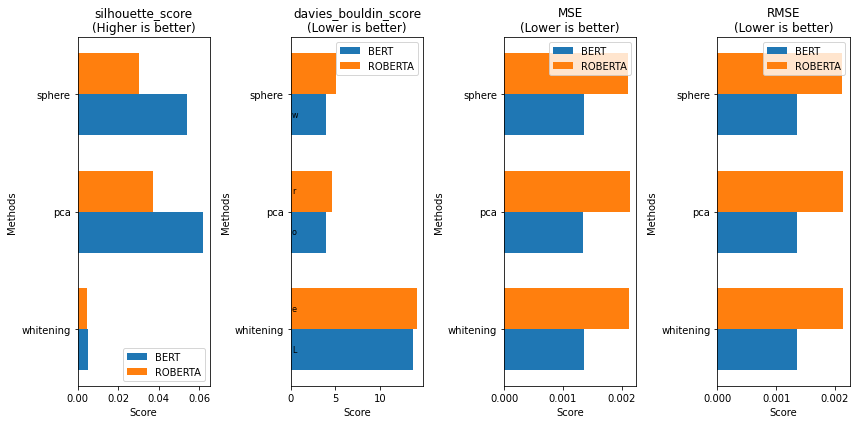

In [ ]:
# Indicate higher-better or lower-better for each metric (optional)
metric_info = {
    "silhouette_score": "Higher is better",
    "davies_bouldin_score": "Lower is better",
    "MSE": "Lower is better",
    "RMSE": "Lower is better"
}


# Number of metrics
num_metrics = len(metrics)

# Create the figure and subplots
fig, axes = plt.subplots(1, num_metrics, figsize=(12, 6))  # Adjust figsize as needed

# Loop through metrics and create subplots
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Extract data for current metric
    scores_arch1 = data[architectures[0]][metric]
    scores_arch2 = data[architectures[1]][metric]

    # Create horizontal bar plot
    bar_width = 0.35
    index = range(len(methods))
    bar1 = ax.barh(index, scores_arch1, bar_width, label=architectures[0])
    bar2 = ax.barh([p + bar_width for p in index], scores_arch2, bar_width, label=architectures[1])

    # Set labels and title
    ax.set_xlabel("Score")
    ax.set_ylabel("Methods")
    ax.set_title(metric)

    # Set y-axis ticks and labels
    ax.set_yticks([p + bar_width / 2 for p in index])
    ax.set_yticklabels(methods)

    # Determine y-axis limits for annotation placement
    y_min, y_max = ax.get_ylim()

    # Add legend
    ax.legend()

    # Annotate bars with metric information (if provided)
    if metric_info:
        for j, (rect, info) in enumerate(zip(bar1 + bar2, metric_info[metric])):
            y_center = rect.get_y() + rect.get_height() / 2
            x_center = 0.1  # Adjust x-position for better visibility
            ax.annotate(info, (x_center, y_center), ha='left', va='center', fontsize=8)

    # Subplot title with metric information
    ax.set_title(f"{metric}\n({metric_info[metric]})")  # Add metric info in subtitle


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define data
methods = ["Method 1", "Method 2", "Method 3"]
metric1_scores = [0.8, 0.7, 0.6]
metric2_scores = [0.9, 0.8, 0.7]

# Indicate higher-better or lower-better for each metric
metric_info = ["Higher is better", "Lower is better"]

# Create separate figures for each metric
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

# Create bars for each metric
bar_width = 0.35
index = range(len(methods))

ax1.barh(index, metric1_scores, bar_width, label=metric1_scores[0])
ax2.barh(index, metric2_scores, bar_width, label=metric2_scores[0])

# Set labels and titles for each plot
ax1.set_xlabel("Score")
ax1.set_ylabel("Methods")
ax1.set_title(f"Comparison of {metric_info[0]} for Different Methods")

ax2.set_xlabel("Score")
ax2.set_ylabel("Methods")
ax2.set_title(f"Comparison of {metric_info[1]} for Different Methods")

# Set y-axis ticks and labels for both plots
for ax in [ax1, ax2]:
    ax.set_yticks([p + bar_width / 2 for p in index])
    ax.set_yticklabels(methods)

# Add legends for both plots
for ax in [ax1, ax2]:
    ax.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

arr = np.random.rand(96000, 768)

vecs = np.concatenate([arr], axis=0)
mu = vecs.mean(axis=0, keepdims=True)

# Center the data
centered_vecs = vecs - vecs.mean(axis=0, keepdims=True)

# Apply PCA
pca = PCA()
pca.fit(centered_vecs)
res_pca = pca.transform(centered_vecs)

print(res_pca.shape)
print(np.cov(vecs.T).shape)
print(pca.components_.shape)
print(mean_squared_error(np.cov(vecs.T), pca.components_))

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(pca.components_)

# Apply ZCA whitening
zca_matrix = eigenvectors * np.diag(1 / np.sqrt(eigenvalues + 1e-5)) @ eigenvectors.T
# whitened_vectors = np.dot(centered_vecs, zca_matrix)

# print(whitened_vectors.shape)



# cross_corr_matrix = np.corrcoef(arr.T, whitened_vectors.T)[:arr.shape[1], arr.shape[1]:]
# cross_cov_matrix = np.cov(arr.T, whitened_vectors.T)[:arr.shape[1], arr.shape[1]:]
# abs_cross_cov_matrix = np.abs(cross_cov_matrix)

# print(cross_corr_matrix)
# print(abs_cross_cov_matrix)

(96000, 768)
(768, 768)
(768, 768)
0.0013113076470131866


In [ ]:
import numpy as np

arr = np.random.rand(96000, 768)
vecs = np.concatenate([arr], axis=0)
mu = vecs.mean(axis=0, keepdims=True)
cov = np.cov(vecs.T)
u, s, vh = np.linalg.svd(cov)
W = np.dot(u, np.diag(s**0.5))
W = np.linalg.inv(W.T)

print(W.shape)

(768, 768)


In [ ]:
cross_correlations = []
cross_covariances = []
for i in range(arr.shape[1]):  # Number of original features
    original_feature = arr[:, i]
    whitened_feature = whitened_vectors[:, i]
    cross_corr = np.correlate(original_feature, whitened_feature)
    cross_correlations.append(cross_corr) 
    cross_cov = np.cov(original_feature, whitened_feature)[0, 1]  # Extract covariance value
    cross_covariances.append(cross_cov)

In [ ]:
print(np.array(cross_correlations).mean())
print(np.array(cross_covariances).mean())

(-0.1500645834741608+0.22703344591863212j)
(-1.563189027739125e-06+2.3649563632830636e-06j)


In [50]:
import torch
import torch.nn as nn

# Define the model class
class TransformerAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(TransformerAttention, self).__init__()
        self.num_heads = num_heads
        
        # Define the linear layers for Q, K, V
        self.query_layer = nn.Linear(input_dim, hidden_dim)
        self.key_layer = nn.Linear(input_dim, hidden_dim)
        self.value_layer = nn.Linear(input_dim, hidden_dim)
        
        # Scaling factor for the dot product attention
        self.scale_factor = (hidden_dim // num_heads) ** 0.5
    
    def forward(self, input):
        # Generate Q, K, V embeddings from the input
        Q = self.query_layer(input)  # Query embeddings
        K = self.key_layer(input)    # Key embeddings
        V = self.value_layer(input)  # Value embeddings

        print(input.shape)
        print(Q.shape)
        print(K.shape)
        print(V.shape)
        print("==============================================================")

        
        # Reshape the embeddings for multi-head attention
        batch_size, seq_len, hidden_dim = Q.shape

        print(Q.view(batch_size, seq_len, self.num_heads, hidden_dim // self.num_heads).shape)

        print("==============================================================")

        Q = Q.view(batch_size, seq_len, self.num_heads, hidden_dim // self.num_heads).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, hidden_dim // self.num_heads).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, hidden_dim // self.num_heads).transpose(1, 2)

        print(Q.shape)
        print(K.shape)
        print(V.shape)
        print("==============================================================")
        
        # Compute the dot product attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale_factor
        print(attention_scores.shape)
        print("==============================================================")
        
        # Apply softmax to normalize the attention scores
        attention_weights = nn.functional.softmax(attention_scores, dim=-1)
        print(attention_weights.shape)
        print("==============================================================")
        
        # Compute the weighted sum of values
        output = torch.matmul(attention_weights, V)
        print(output.shape)
        print("==============================================================")
        
        print(output.transpose(1, 2).shape)
        # Reshape the output back to the original shape
        output = output.transpose(1, 2).reshape(batch_size, seq_len, hidden_dim)
        print("==============================================================")
        
        return output 


In [63]:
a = torch.randn(32, 4, 10, 32)
b = a.transpose(-2,-1)
print(b.shape)
print((torch.matmul(a,b) / 3.2 ).shape)
# print(input_data.transpose(1, 2).transpose(-2, -1).shape)

torch.Size([32, 4, 32, 10])
torch.Size([32, 4, 10, 10])


In [68]:
input_data = torch.rand(2,3)
result = nn.functional.softmax(input_data, dim=-1)
print(input_data)
print(result)

tensor([[0.0121, 0.2266, 0.4699],
        [0.5219, 0.9296, 0.1143]])
tensor([[0.2618, 0.3244, 0.4138],
        [0.3156, 0.4744, 0.2100]])


In [51]:
# Input data: batch_size x seq_len x input_dim
input_data = torch.randn(32, 10, 64)  # Batch of 32 sequences, each with length 10 and embedding dimension 64

# Define the attention layer
attention_layer = TransformerAttention(input_dim=64, hidden_dim=128, num_heads=4)

# Apply the attention layer
output = attention_layer(input_data)

print("Output shape:", output.shape)  # Expected output shape: (32, 10, 128)

torch.Size([32, 10, 64])
torch.Size([32, 10, 128])
torch.Size([32, 10, 128])
torch.Size([32, 10, 128])
torch.Size([32, 10, 4, 32])
torch.Size([32, 4, 10, 32])
torch.Size([32, 4, 10, 32])
torch.Size([32, 4, 10, 32])
torch.Size([32, 4, 10, 10])
torch.Size([32, 4, 10, 10])
torch.Size([32, 4, 10, 32])
torch.Size([32, 10, 4, 32])
Output shape: torch.Size([32, 10, 128])


In [6]:
w = 10
.1e-5

1e-06